In [1]:
import numpy as np
import pandas as pd
from os import listdir

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# in case this error appear
# Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead

# may need to update or change the version of this libs in case the lineplot not work, 

print('sns: ',sns.__version__, 'used: 0.13.0')
print('plt: ',matplotlib.__version__, 'used: 3.8.2')

# pip install seaborn==0.13.0
# or
# pip install seaborn --upgrade

sns:  0.13.0 desired: 0.13.0
plt:  3.5.1 desired: 3.8.2


In [2]:
# get the number of valid individuos from each iteration
def get_n_valids(file_path, file_name, use_P_B_as_valid=False):
    # load
    col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
    df = pd.read_csv(file_path+'/'+file_name, header=None, skiprows=1, names=col_names)
    
    if use_P_B_as_valid:
        df['valid'] = (df['P_B'] > 0)
    else:
        # penalty and valid were not saved in this test, so need to be created
        df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
        df['valid'] = (df['penalty'] == 0)
    
    #
    iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
    iteration_counter_lines = np.insert(iteration_counter_lines, 0, -1) # # add the start -1 as the first element

    n_valids_list = []
    for k in range(len(iteration_counter_lines)-1):
        i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
        size = iteration_counter_lines[k+1] - i
        locs = [f for f in range(i, i+size)] # get the 12 elements from that iteration
    #     print('i', i, ' np_size', size, 'locs', locs)
        n_valids = df.iloc[locs]['valid']
        n_valids = sum(n_valids)
        n_valids_list.append(n_valids)
    return n_valids_list

In [3]:
# biggest percentage of difference on each individual parameter
def diff(x, y, ignore_last=False):
    max_diff = 0
    end = 1 if ignore_last else 0 # remove 1 from len if ignore_last
    for i in range(len(x) - end):
        cur_diff = abs(x[i] - y[i]) / max(x[i], y[i])
        max_diff = max(max_diff, cur_diff)
    return max_diff

# list of tuples, (differents, number of individuals) for each generation
def get_n_differents(file_path, file_name, only_valids=True, use_P_B_as_valid=False, threshold=0.004):
    # load
    col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
    df = pd.read_csv(file_path+'/'+file_name, header=None, skiprows=1, names=col_names)
    
    if use_P_B_as_valid:
        df['valid'] = (df['P_B'] > 0)
    else:
        # penalty and valid were not saved in this test, so need to be created
        df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
        df['valid'] = (df['penalty'] == 0)
    
    #
    iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
    iteration_counter_lines = np.insert(iteration_counter_lines, 0, -1) # # add the start -1 as the first element

    n_diffs_list = []
    n_totals_list = []
    for k in range(len(iteration_counter_lines)-1):
        i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
        size = iteration_counter_lines[k+1] - i
        locs = [f for f in range(i, i+size)] # get the 12 elements from that iteration
        
        # df.iloc[locs] contains one iteration
        df_temp = df.iloc[locs][['D', 'AEdAO', 'PdD', 'Z']]
        df_temp = df_temp.astype({'D':float, 'AEdAO':float, 'PdD':float, 'Z':int})
        # valids
        valids_np = df.iloc[locs]['valid'].to_numpy()
        
        # for the elements comparing with each other
        df_temp_np = df_temp.to_numpy()
        diffs_np = np.ones(len(df_temp_np)) # got to be 1 so the last one is bigger than the threshold, since it's not being compared with the others
        for i in range(len(df_temp_np)-1):
            elem_i = df_temp_np[i]
            min_diff = float('inf')
            # compare with the next elements in the list
            for j in range(i+1, len(df_temp_np)):
                elem_j = df_temp_np[j]
                curr_diff = diff(elem_i, elem_j, ignore_last=True)
                curr_diff += abs(df_temp_np[i][-1] - df_temp_np[j][-1])
                min_diff = min(min_diff, curr_diff)
            # 
            diffs_np[i] = min_diff
        equals_np = [min_diff < threshold for min_diff in diffs_np]
        # differents = not equals
        differents_np = np.logical_not(equals_np)
        # if only_valids then get only differents that are also valid
        if only_valids:
            differents_np = np.logical_and(differents_np, valids_np)
        #
        n_diffs  = sum(differents_np)
        n_totals = len(differents_np)
        n_diffs_list.append(n_diffs)
        n_totals_list.append(n_totals)
    return [n_diffs_list, n_totals_list]


## Calculate the difs

In [5]:
# path for the dir for the runs, containing each dir for a VS
# path_run =  '../Main/run/'
path_run = 'validGraphRuns/'

# number of generations
n_generations = 30

In [6]:
valids_by_vs = {}


for vs in ['7_0', '7_5', '8_0', '8_5']:
    file_path = path_run + vs
    print('loading', vs)
    
    # solvers depending on the vs
    solvers = ['cmaes', 'openaies', 'original']
    
    if vs in ['7_0', '7_5']:
        solvers.append('original_old')
    
    # create dir for the solver depending on vs
    valids_by_vs[vs] = {}
    # counter for number of runs (for each solver)
    counter = {}
    
    # init dir with 0
    for solver in solvers:
        valids_by_vs[vs][solver] = np.zeros(n_generations, dtype=int)
        counter[solver] = 0
        
    # for each run dir containg the solvers 
    for run_dir_name in listdir(file_path):
        for solver in solvers:
            # read file
            temp_path = file_path + '/' + run_dir_name + '/' + solver
            for file_name in listdir(temp_path):
                n_valids, _ = get_n_differents(temp_path, file_name, use_P_B_as_valid=(solver == 'original_old'), only_valids=True)

                # difEvo has generation 0 together with 1 for some reason (0 is an extra generation I guess)
                # do the ceil of mean of this 2 generations
                if 'original' in solver :
                    n_valids[0] = int((n_valids[0] / 2) + 0.6)
                
                valids_by_vs[vs][solver] = np.add(valids_by_vs[vs][solver], n_valids)
            # count by run (not by Z file) 
            counter[solver] += 1
                
    # after passed the for each run dir
    for solver in solvers:
        # get the mean
        valids_by_vs[vs][solver] = np.divide(valids_by_vs[vs][solver], counter[solver])

loading 7_0
loading 7_5
loading 8_0
loading 8_5


In [24]:
#
valids_by_vs['7_0']

{'cmaes': array([ 5.5, 13.6, 17.3, 20. , 24.1, 26.7, 25.6, 26.1, 26.9, 27.3, 26.7,
        26.5, 26.1, 25.1, 26.5, 26.4, 25.4, 24.6, 25.2, 23.6, 21.7, 23.5,
        22.2, 20.6, 19.3, 20.1, 18.7, 18.4, 16.6, 16.1]),
 'openaies': array([ 6.1, 13.3, 19.2, 22.5, 28.7, 29.9, 29.7, 29.5, 29.8, 29.7, 29.1,
        29.7, 29.3, 28.4, 27. , 27.2, 25.4, 25.6, 26.3, 25.8, 25. , 26.3,
        25.6, 27. , 27.6, 27.4, 28.3, 27.8, 28.2, 28.8]),
 'original': array([ 3.6,  4.2,  4.1,  5.3,  6. ,  8.7, 10.4, 12.1, 12.9, 15.2, 15.8,
        18.2, 20.9, 20.7, 20.2, 23. , 22.8, 21.8, 23.2, 23.9, 23.3, 24.1,
        24.3, 24.5, 22.3, 22.4, 23.6, 23.7, 24.6, 24.7]),
 'original_old': array([ 8.1, 23. , 23.6, 23.6, 26. , 25.7, 24.5, 26. , 25.4, 26.4, 26.1,
        26.7, 26.6, 25.8, 25.6, 25.9, 25.8, 26.1, 25.2, 24.8, 26.1, 26.1,
        25. , 25.5, 25. , 23.6, 25.2, 24.7, 24.8, 24. ])}

## Show Graph

In [25]:
solver_names = {'cmaes':   'CMA-ES', 
                'openaies': 'OpenAI-ES', 
#                 'original': 'DE Modificado', # pt
                'original': 'DE Replicated', # en
#                 'original_old': 'DE Base'  # pt
                'original_old': 'DE Proposed'  # en
               }

line_styles = {'cmaes': 'solid',
               'openaies': 'dashdot',
               'original': 'dotted',
               'original_old':'dashed'
              }

In [26]:
def create_graph(vs):
    plt.rcParams.update({'font.size': 14})
    
    plt.figure(figsize=(7,4), dpi=100)


    x = [valids_by_vs[vs][solver] for solver in valids_by_vs[vs]]
    lines = []
    for solver in valids_by_vs[vs]:
        line, = plt.plot(valids_by_vs[vs][solver],
                         linewidth=1.5, 
                         color='black', 
                         linestyle=line_styles[solver], 
                         label=solver_names[solver]
                        ) 
        lines.append(line)

    plt.xlabel('generation')
    plt.ylabel('number of valid different configurations')
#     plt.legend(handles=lines, loc='lower right')
    plt.legend(handles=lines, loc='upper left', bbox_to_anchor=(1, 1))

    plt.title('VS = '+vs.replace('_','.'))
    
    plt.ylim(0, 30)
    
    plt.show()

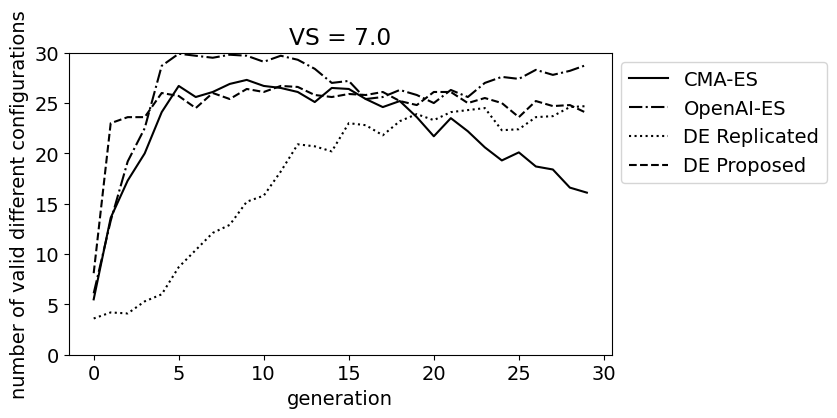

In [11]:
create_graph('7_0')

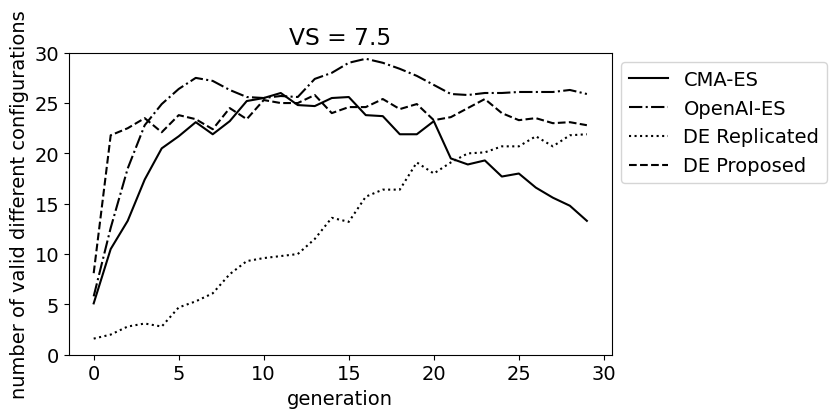

In [12]:
create_graph('7_5')

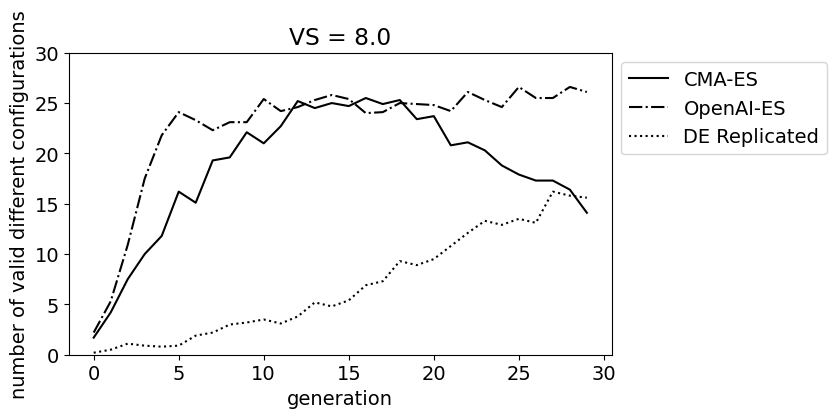

In [13]:
create_graph('8_0')

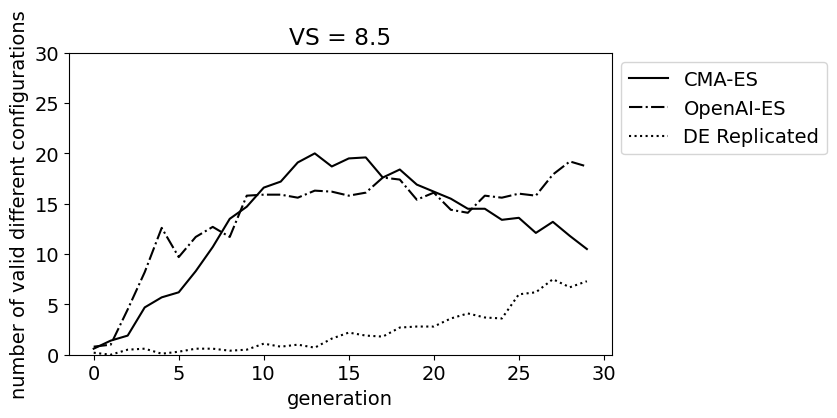

In [14]:
create_graph('8_5')

# Graphs for the article

In [18]:
y_axis_label = 'Number of different\nvalid configurations'   # en
# y_axis_label = 'Número de diferentes\nconfigurações válidas' # pt

x_axis_label = 'Generation' # en
# x_axis_label = 'Geração'    # pt

font_size = 18

In [21]:
def create_double_graph(vs1, vs2, save=False):
    # Create a larger figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figsize as needed
#     plt.rcParams.update({'font.size': 15})

    # Create the first plot
    x = [valids_by_vs[vs1][solver] for solver in valids_by_vs[vs1]]
    lines = []
    for solver in valids_by_vs[vs1]:
        line, = ax1.plot(valids_by_vs[vs1][solver],
                         linewidth=1.5, 
                         color='black', 
                         linestyle=line_styles[solver], 
                         label=solver_names[solver]
                        ) 
        lines.append(line)
    ax1.set_xlabel(x_axis_label, fontsize=font_size)
    ax1.set_ylabel(y_axis_label, fontsize=font_size) 
    ax1.legend([],[], frameon=False)
    ax1.set_title('VS = '+vs1.replace('_','.'), fontsize=font_size)
    ax1.set_ylim(0, 30)

    # Create the second plot
    x = [valids_by_vs[vs2][solver] for solver in valids_by_vs[vs2]]
    lines = []
    for solver in valids_by_vs[vs2]:
        line, = ax2.plot(valids_by_vs[vs2][solver],
                         linewidth=1.5, 
                         color='black', 
                         linestyle=line_styles[solver], 
                         label=solver_names[solver]
                        ) 
        lines.append(line)
    ax2.set_xlabel(x_axis_label, fontsize=font_size)
    ax2.set_ylabel(y_axis_label, fontsize=font_size)
    ax2.legend(handles=lines, loc='upper left', bbox_to_anchor=(1, 1))
    ax2.set_title('VS = '+vs2.replace('_','.'), fontsize=font_size)
    ax2.set_ylim(0, 30)
    
    # ajusts
    plt.tight_layout()
    
    # save
    if save:
        name_f = 'diffs_'+ vs1 + 'and' + vs2 + '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved as:', name_f)
        
    
    # Display the plots
    plt.show()


saved as: diffs_7_0and7_5.pdf


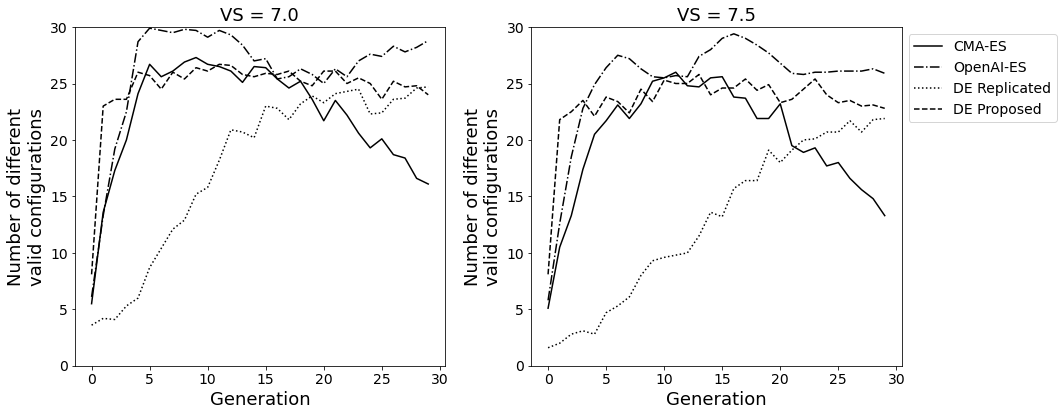

In [22]:
create_double_graph('7_0', '7_5', save=True)

saved as: diffs_8_0and8_5.pdf


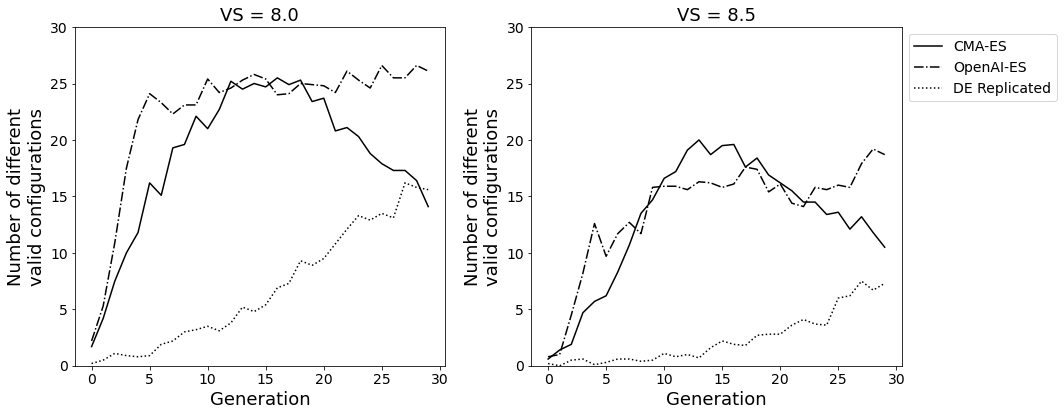

In [23]:
create_double_graph('8_0', '8_5', save=True)